<div style="text-align: center;">
    <img src="https://user-images.githubusercontent.com/86345471/221379942-51f24819-1f76-4289-8dee-06ea69f730f6.png" alt=Main "KPI />
</di>

<hr>

**Завдання:** Зробити парсинг певної соцмережі (фейсбук, тредс, Х чи т.п.) та  створити БД для виявлення певних повідомлень (ключових слів). Зробити аналіз на виявлення аномальної поведінки(наприклад використання тригерних слів). Як розширення – якщо аналітика вивлиться інформтивною – виявляти ботів.

**Теорія:** Парсинг соціальних мереж є процесом автоматизованого збору даних із відкритих джерел, таких як коментарі під дописами користувачів. Для цього використовуються API-методи, що дозволяють отримувати структуровані дані, що зберігатимуться у базі даних для подальшого аналізу. Одним із напрямів обробки таких даних є виявлення повідомлень, що містять заздалегідь визначені ключові або тригерні слова, які можуть сигналізувати про специфічний контекст або наявність інформаційного впливу. Подальший аналіз поведінкових характеристик користувачів (частота публікацій, активність у нічний час, середня довжина коментарів тощо) дозволяє здійснювати ідентифікацію аномальної або підозрілої активності, зокрема виявлення автоматизованих або бото-подібних акаунтів.

<hr>

### 1. 📦 Імпорт бібліотек та модулів

In [1]:
import praw

import sqlite3
import pandas as pd

from datetime import datetime
from collections import Counter

import seaborn as sns
import matplotlib.pyplot as plt

### 2. 🌐 Отримання дописів із Reddit

In [2]:
client_id = "jM8Jm6I6Z-Lc_o_R1P4DKw"
client_secret = "C79uVX4fnzyJragangyHZWTDDYy-ng"
user_agent = "reddit-analysis-script/0.1"

reddit = praw.Reddit(
    client_id=client_id,
    client_secret=client_secret,
    user_agent=user_agent
)

In [3]:
keywords = ["Zelensky"]
subreddit_name = "worldnews"

limit_posts = 1000
comments_data = []

matched_posts = 0 

for i, submission in enumerate(reddit.subreddit(subreddit_name).new(limit=limit_posts), start=1):
    print(f"[{i}] Fetching comments from post: \"{submission.title}\"")

    submission.comments.replace_more(limit=0)
    found_in_this_post = False

    for comment in submission.comments.list():
        text = comment.body.lower()

        if any(word.lower() in text for word in keywords):
            comments_data.append({
                "post_id": submission.id,
                "post_title": submission.title,
                "comment_id": comment.id,
                "comment_body": comment.body,
                "author": str(comment.author),
                "created_utc": comment.created_utc,
                "score": comment.score
            })
            found_in_this_post = True

    if found_in_this_post:
        matched_posts += 1

[1] Fetching comments from post: "Trump ‘delighted’ by his influence on Canada’s election: U.S. journalist - National | Globalnews.ca"
[2] Fetching comments from post: "Trump on Iran Nuclear Talks: Goal is "Complete Dismantlement", but open to hearing about "Civilian" nuclear program"
[3] Fetching comments from post: "U.S. President Trump considers military action for Greenland acquisition, citing national security"
[4] Fetching comments from post: "Trump still would like to add Canada and Greenland but says attack on Canada ‘highly unlikely’"
[5] Fetching comments from post: "Netanyahu vows to retaliate against Houthis and Iran after missile attack"
[6] Fetching comments from post: "Czech president: We are discussing artillery shell supplies to Ukraine for 2026"
[7] Fetching comments from post: "Trump mostly — but not entirely — rules out military action on Canada"
[8] Fetching comments from post: ""There may be": Zelenskyy commented on possible provocations by Russia on May 9 in Mosc

In [4]:
df = pd.DataFrame(comments_data)
df.sample(10)

,post_id,post_title,comment_id,comment_body,author,created_utc,score
340,1kawxrn,Rubio Warns US To End Mediation Unless 'Concre...,mppzohd,Zelensky has been telling Trump that Putin can...,TrashCapable,1.745958e+09,4
58,1kegdat,Zelenskyy: Trump says Russia won’t touch Ukrai...,mqk4jqm,Zelenskyy is smart. I don't know where he's go...,SparrowValentinus,1.746376e+09,1
667,1k6jb4s,/r/WorldNews Live Thread: Russian Invasion of ...,mosmkzl,> It has been 44 days since Ukraine agreed to ...,M795,1.745505e+09,26
581,1k7iidg,Ukraine may have to give up land for peace - K...,moyclur,Klitschko is more of a fighter than Zelensky w...,Evindow,1.745581e+09,-8
395,1kaf2hz,/r/WorldNews Live Thread: Russian Invasion of ...,mpqp7su,> It’s important to keep applying pressure on ...,M795,1.745966e+09,25
65,1kegdat,Zelenskyy: Trump says Russia won’t touch Ukrai...,mqjmss5,"I think Zelensky knows that, but knows that sa...",way2lazy2care,1.746371e+09,7
715,1k65vfz,Trump blames Zelenskyy for rejecting Ukraine-R...,mplh089,It wasn’t. Capitulation is the only deal Russi...,minuetteman,1.745895e+09,1
51,1kegdat,Zelenskyy: Trump says Russia won’t touch Ukrai...,mqjvrmp,Zelensky is delusional. If Russia defeats Ukra...,badmoonrisingnl,1.746373e+09,1
384,1kam4g2,Russia rejects Trump’s proposed peace deal,mpofrpb,But Zelenskyy didn't say thank you enough to g...,anotherfrud,1.745942e+09,26
589,1k7h76x,Russia: Some elements of peace deal with Ukrai...,moytmf6,>Trump's deal in incredibly Pro-Russia.\n\nHes...,Melotron,1.745588e+09,1


### 3. 🗃️ Створення SQLite БД (In-Memory)

In [5]:
conn = sqlite3.connect(":memory:")

create_table_sql = """
CREATE TABLE IF NOT EXISTS reddit_posts (
    post_id TEXT,
    post_title TEXT,
    comment_id TEXT PRIMARY KEY,
    comment_body TEXT,
    author TEXT,
    created_utc REAL,
    score INTEGER
)
"""
conn.execute(create_table_sql)
conn.commit()

In [6]:
try:
    df.to_sql("reddit_posts", conn, index=False, if_exists="append")
except sqlite3.IntegrityError:
    print("⚠️ Unable to insert comment that was added before!")

In [7]:
db = pd.read_sql("SELECT * FROM reddit_posts", conn)
db

,post_id,post_title,comment_id,comment_body,author,created_utc,score
0,1kenvxh,Trump mostly — but not entirely — rules out mi...,mqk9ap9,I think you would have to make that a conditio...,Little_Blue_Marble,1.746378e+09,1
1,1kegdat,Zelenskyy: Trump says Russia won’t touch Ukrai...,mqjd2qm,Zelenskyy knows better than to trust Trump. I ...,pripjat,1.746367e+09,61
2,1kegdat,Zelenskyy: Trump says Russia won’t touch Ukrai...,mqiikhe,"Trump is fickle, everyone knows this. But him ...",nuttininyou,1.746354e+09,61
3,1kegdat,Zelenskyy: Trump says Russia won’t touch Ukrai...,mqj64hl,"Ukraine, if reaching an undoing, will be becau...",Juuiken,1.746365e+09,4
4,1kegdat,Zelenskyy: Trump says Russia won’t touch Ukrai...,mqj8tez,It's the right way to suck up to him but godda...,ensignlee,1.746366e+09,3
...,...,...,...,...,...,...,...
807,1k5rgs9,Rubio to skip Ukraine talks as Zelensky reject...,moomoq2,If only Rubio and Trump had Zelenskyy’s integr...,Ok-Ordinary2035,1.745445e+09,2
808,1k5rgs9,Rubio to skip Ukraine talks as Zelensky reject...,mokdnuk,Rubio ain't going cause President Zelensky wo...,Adept-Mulberry-8720,1.745389e+09,1
809,1k5rgs9,Rubio to skip Ukraine talks as Zelensky reject...,moqvbxq,Sure the only way it would have worked is if U...,free2bk8,1.745476e+09,1
810,1k5rgs9,Rubio to skip Ukraine talks as Zelensky reject...,mokr0da,He already has his instructions. Probably toda...,Anomuumi,1.745397e+09,14


### 4. 🚨 Виявлення тригерних (осудливих) cлів

In [8]:
trigger_words = [
    "traitor", "corrupt", "liar", "dictator", "puppet", "clown", "incompetent",
    "shame", "kremlin agent", "failure", "fake", "murderer", "occupier",
    "authoritarian", "regime", "repression", "persecution", "totalitarian",
    "loser", "infantile", "criminal", "sellout", "nazi", "warmonger", "mobster"
]


def detect_trigger_words(text):
    text = text.lower()
    return any(word in text for word in trigger_words)

In [9]:
db["is_triggered"] = df["comment_body"].apply(detect_trigger_words)
db_triggered = db[db["is_triggered"] == True]
db_triggered

,post_id,post_title,comment_id,comment_body,author,created_utc,score,is_triggered
6,1kegdat,Zelenskyy: Trump says Russia won’t touch Ukrai...,mqjx5jq,Zelensky. Poor guy. Having no other option but...,Equivalent_Kick9858,1.746374e+09,3,True
43,1kegdat,Zelenskyy: Trump says Russia won’t touch Ukrai...,mqjix6u,Zelenskyy never should have signed that minera...,Agitated-Isopod10,1.746369e+09,1,True
44,1kegdat,Zelenskyy: Trump says Russia won’t touch Ukrai...,mqjjdko,"First off, I'm sure Zelenskyy doesn't believe ...",Harry_Mud,1.746370e+09,1,True
70,1kegdat,Zelenskyy: Trump says Russia won’t touch Ukrai...,mqiv1oj,Exactly… allow me to add to this and let’s jus...,billshermanburner,1.746360e+09,23,True
81,1kegdat,Zelenskyy: Trump says Russia won’t touch Ukrai...,mqj04gl,It's funny.\n\nTrump calls Zelensky a dictator...,42nu,1.746363e+09,9,True
...,...,...,...,...,...,...,...,...
746,1k63kei,'This is a very dangerous moment' — Zelensky w...,moppoo7,There were also millions of former democrats t...,TeaAndLifting,1.745458e+09,11,True
764,1k5ut44,High-profile Ukraine peace talks collapse,molbtl6,"Once again, Zelenskyy comes out looking like t...",illarionds,1.745409e+09,7,True
768,1k5ut44,High-profile Ukraine peace talks collapse,monhz3q,Hmmm Ukraine has to negotiate for which parts ...,TheMobster100,1.745433e+09,1,True
784,1k5s3dw,"Trump's ""final offer"" for peace requires Ukrai...",momjce6,"U.S. citizen here,\n\nI am **pro-Ukraine.**\n\...",Whatever-999999,1.745423e+09,3,True


### 5. 📈 Аналіз частоти тригерних твітів

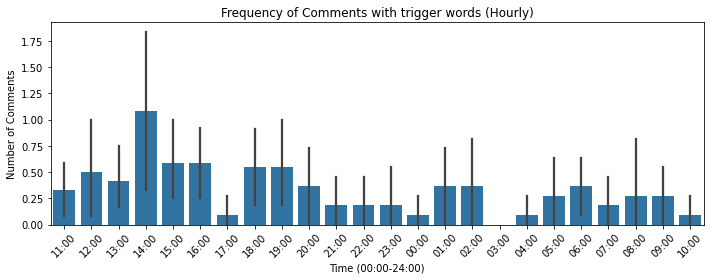

In [10]:
db["created_at"] = pd.to_datetime(db["created_utc"], unit="s")
db = db.set_index("created_at")

trigger_freq = db[db["is_triggered"]].resample("1H").size()

plt.figure(figsize=(10, 4))
sns.barplot(x=trigger_freq.index.strftime("%H:%M"), y=trigger_freq.values)
plt.xticks(rotation=45)

plt.title("Frequency of Comments with trigger words (Hourly)")
plt.xlabel("Time (00:00-24:00)")
plt.ylabel("Number of Comments")

plt.tight_layout()

### 6. 📊 Загальні висновки по коментарях

In [11]:
print(f"🔍 Total comments analyzed: {len(db)}")
print(f"⚠️ Comments with trigger words: {len(db_triggered)} ({len(db_triggered) / len(db):.2%})")

trigger_counter = Counter()
for text in db_triggered["comment_body"]:
    words = text.lower().split()
    trigger_counter.update([w for w in words if w in trigger_words])

print("\n🔥 Top 5 trigger words:")
for word, count in trigger_counter.most_common(5):
    print(f" - {word}: {count}")

top_authors = db_triggered["author"].value_counts().head(5)
print("\n👤 Top authors by number of triggered comments:")
print(top_authors)

print("\n📝 Sample Triggered Comments:\n" + "-"*40)
for i, row in db_triggered.sample(5).iterrows():
    comment = row["comment_body"].replace("\n", " ")
    comment = (comment[:300] + "...") if len(comment) > 300 else comment
    print(f"🔢 {i+1}\n👤 {row['author']}\n💬 {comment}\n")

🔍 Total comments analyzed: 812
⚠️ Comments with trigger words: 91 (11.21%)

🔥 Top 5 trigger words:
 - dictator: 12
 - fake: 6
 - criminal: 6
 - puppet: 6
 - corrupt: 4

👤 Top authors by number of triggered comments:
M795                   5
JohnBPrettyGood        2
Aware-Chipmunk4344     2
Axelrad77              2
Equivalent_Kick9858    1
Name: author, dtype: int64

📝 Sample Triggered Comments:
----------------------------------------
🔢 584
👤 SeaConfusion6213
💬 “Zelenskyy said on X preliminary analysis had linked the Russian attack to a ballistic missile manufactured in North Korea.       The president had harsh words for Pyongyang:       “If the information that this missile was made in North Korea is confirmed, this will be further proof of the criminal ...

🔢 345
👤 VOIDsama
💬 if trump stepped in and actually supported Ukraine, committed to such publicly and repeatedly, Putin would be much more willing to actually negotiate.  Hell Zelensky would likely be much more open to concession

### **. 🤖 Виявлення ботів (спрощена логіка)

In [12]:
db["created_at"] = pd.to_datetime(db["created_utc"], unit="s")

db["hour"] = db["created_at"].dt.hour
db["day"] = db["created_at"].dt.date

bot_users = []
grouped = db.groupby("author")

for author, group in grouped:
    if len(group) < 5:
        continue

    trigger_count = group["is_triggered"].sum()
    short_count = (group["comment_body"].str.len() < 10).sum()
    night_count = group[(group["hour"] >= 0) & (group["hour"] <= 5)].shape[0]

    trigger_ratio = trigger_count / len(group)
    short_ratio = short_count / len(group)
    night_ratio = night_count / len(group)

    if (
        trigger_ratio > 0.18 or
        short_ratio > 0.24 or
        night_ratio > 0.32
    ):
        bot_users.append(author)

db["is_bot"] = db["author"].isin(bot_users)

print(f"|☼☼| Detected {len(bot_users)} potential bot accounts!")
print(f"=++= Suspicious users: {bot_users}\n\n")

suspicious_df = db[db["is_bot"]].sort_values(by="author")
suspicious_df.head()

|☼☼| Detected 2 potential bot accounts!
=++= Suspicious users: ['Useful-Scratch-72', 'cuterebro']




,post_id,post_title,comment_id,comment_body,author,created_utc,score,is_triggered,created_at,hour,day,is_bot
created_at,,,,,,,,,,,,
2025-05-04 06:01:20,1keb2ac,/r/WorldNews Live Thread: Russian Invasion of ...,mqhtebb,Zelensky says he won’t play Putin’s ‘games’ wi...,Useful-Scratch-72,1.746338e+09,49,False,2025-05-04 06:01:20,6,2025-05-04,True
2025-04-26 13:58:52,1k8465j,/r/WorldNews Live Thread: Russian Invasion of ...,mp5asyz,Trump and Zelensky have a ‘productive meeting’...,Useful-Scratch-72,1.745676e+09,21,False,2025-04-26 13:58:52,13,2025-04-26,True
2025-04-26 14:08:02,1k8465j,/r/WorldNews Live Thread: Russian Invasion of ...,mp5cejj,Another update on Trump Zelensky meeting.\n\nh...,Useful-Scratch-72,1.745676e+09,21,False,2025-04-26 14:08:02,14,2025-04-26,True
2025-04-26 05:57:55,1k8465j,/r/WorldNews Live Thread: Russian Invasion of ...,mp3qbkg,"The Kyiv Independent, April 26.\n\nhttps://kyi...",Useful-Scratch-72,1.745647e+09,15,False,2025-04-26 05:57:55,5,2025-04-26,True
2025-04-24 05:26:47,1k6jb4s,/r/WorldNews Live Thread: Russian Invasion of ...,moqp725,Putin’s puppet Trump berates Zelensky for not ...,Useful-Scratch-72,1.745472e+09,46,True,2025-04-24 05:26:47,5,2025-04-24,True
